In [1]:
!pip install trimesh
!pip install torch
import os
import trimesh
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
import os
repo_path = "./Pointnet_Pointnet2_pytorch"  
sys.path.append(os.path.abspath(repo_path))
sys.path.append(os.path.abspath(os.path.join(repo_path, "models")))


In [3]:
sydney_datast = r"d:\1508Project\sydney-urban-objects-dataset\sydney-urban-objects-dataset"
objects_path = os.path.join(sydney_datast, "objects")

print(os.listdir(objects_path))

['4wd.0.2299.bin', '4wd.0.2299.bin.meta', '4wd.0.2299.csv', '4wd.1.2446.bin', '4wd.1.2446.bin.meta', '4wd.1.2446.csv', '4wd.10.17589.bin', '4wd.10.17589.bin.meta', '4wd.10.17589.csv', '4wd.11.6994.bin', '4wd.11.6994.bin.meta', '4wd.11.6994.csv', '4wd.12.3582.bin', '4wd.12.3582.bin.meta', '4wd.12.3582.csv', '4wd.13.270.bin', '4wd.13.270.bin.meta', '4wd.13.270.csv', '4wd.14.5229.bin', '4wd.14.5229.bin.meta', '4wd.14.5229.csv', '4wd.15.5563.bin', '4wd.15.5563.bin.meta', '4wd.15.5563.csv', '4wd.16.6123.bin', '4wd.16.6123.bin.meta', '4wd.16.6123.csv', '4wd.17.6783.bin', '4wd.17.6783.bin.meta', '4wd.17.6783.csv', '4wd.18.7288.bin', '4wd.18.7288.bin.meta', '4wd.18.7288.csv', '4wd.19.10974.bin', '4wd.19.10974.bin.meta', '4wd.19.10974.csv', '4wd.2.3582.bin', '4wd.2.3582.bin.meta', '4wd.2.3582.csv', '4wd.20.12346.bin', '4wd.20.12346.bin.meta', '4wd.20.12346.csv', '4wd.3.4043.bin', '4wd.3.4043.bin.meta', '4wd.3.4043.csv', '4wd.4.17038.bin', '4wd.4.17038.bin.meta', '4wd.4.17038.csv', '4wd.5.17038.

In [4]:
def read_bin(file_name):

    names = ['t','intensity','id','x','y','z','azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
               'float32', 'float32', 'float32',
               'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(file_name, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T

    return P

sample = read_bin(r'C:\Users\zqt\.keras\datasets\sydney-urban-objects-dataset_extracted\sydney-urban-objects-dataset\objects\4wd.2.3582.bin')
print(sample.shape)

(204, 3)


In [5]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)
num_classes

26

In [6]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis=1)
    chosen = random.choices(res1, k=k)  
    chosen = np.asarray(chosen)
    
    pcs_out = chosen[:, :-1]
    labels_out = chosen[:, -1]
    return pcs_out, labels_out

class SydneyUrban(Dataset):
    def __init__(self, file_paths, labels, num_points=1024, transform=False):
        self.files = file_paths
        self.labels = labels
        self.num_points = num_points
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        pts = read_bin(self.files[idx])
        label = self.labels[idx]
        
        if pts.shape[0] > self.num_points:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=False)
        else:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=True)
        points = pts[idxs]
        
        points[:, :3] = self.normalize(points[:, :3])
        
        points = torch.from_numpy(points).float()
        label = torch.tensor(label).long()
        
        return points, label
        
    def normalize(self, points):
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(points**2, axis=1)))
        points /= furthest_distance
        return points

In [7]:
all_files = [
    os.path.join(objects_path,f)
    for f in os.listdir(objects_path)
    if f.endswith('.bin') and not f.endswith('.bin.meta')
    ]

all_labels = []
for f in all_files:
    file_name = os.path.basename(f)
    label_str = file_name.split('.')[0]
    num_label = labels_dict[label_str]
    all_labels.append(num_label)

In [8]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42) 
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

train_dataset = SydneyUrban(train_files, train_labels, num_points=1024)
test_dataset = SydneyUrban(test_files, test_labels, num_points=1024)
val_dataset = SydneyUrban(val_files, val_labels, num_points=1024)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

13
4
4


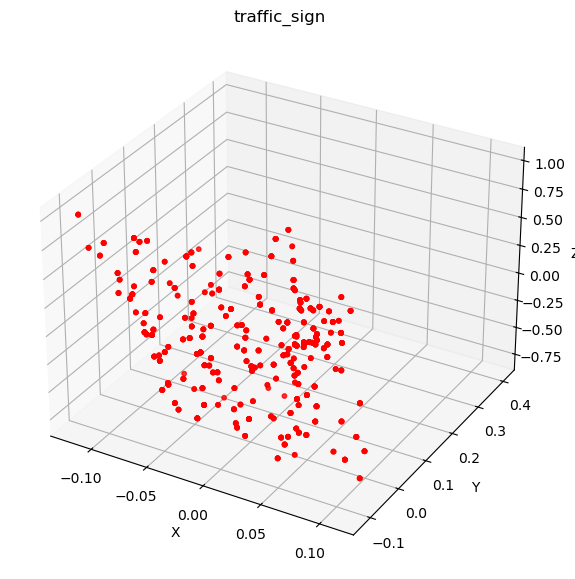

Class: traffic_sign


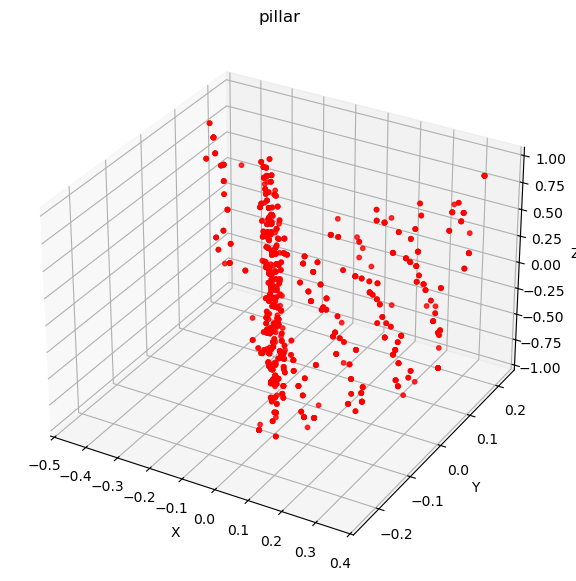

Class: pillar


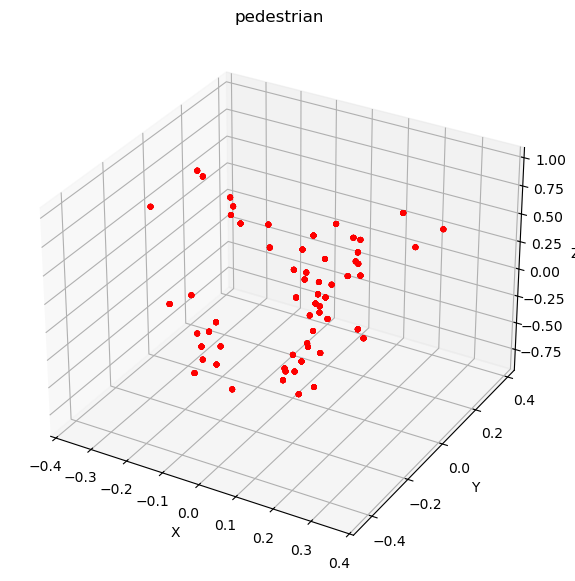

Class: pedestrian


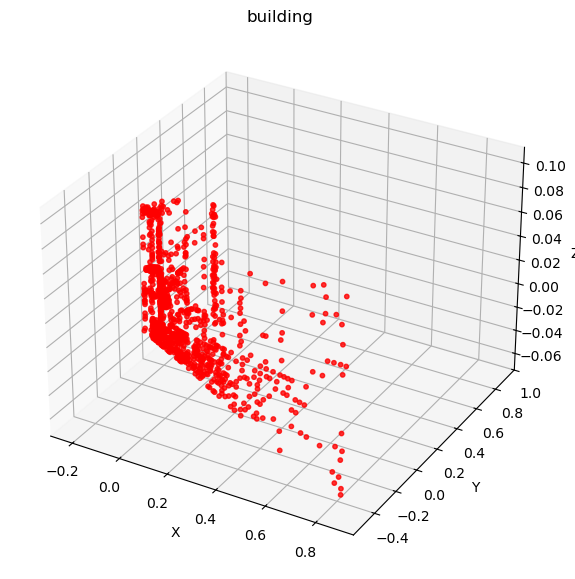

Class: building


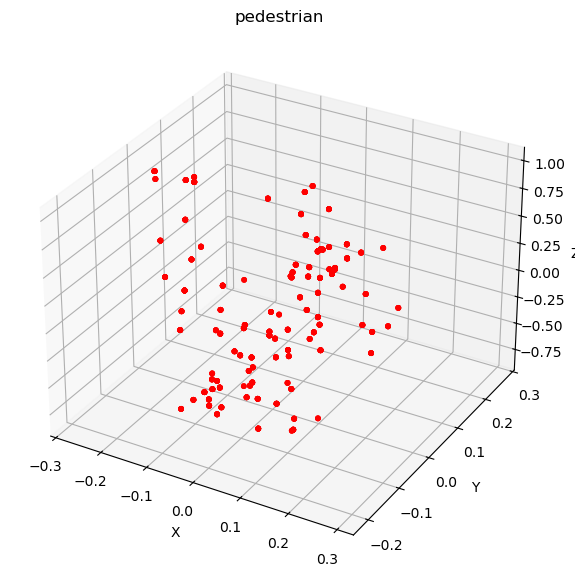

Class: pedestrian


In [9]:
reverse_labels = {v: k for k, v in labels_dict.items()}
def plot_pc(points, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# visualize 5 samples
for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    points = sample[0].numpy()
    label = sample[1].item()
    class_name = reverse_labels[label]
    
    plot_pc(points, class_name)
    print(f"Class: {class_name}")

In [10]:
class TNet(nn.Module):
  def __init__(self, k = 3):
    super().__init__()
    self.k = k

    self.conv1 = nn.Conv1d(in_channels=k, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=k*k)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    batch_size = x.size(0)

    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))

    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    iden = torch.eye(self.k, requires_grad=False).repeat(batch_size, 1, 1).to(x.device)
    x = x.view(-1, self.k, self.k)
    x = x + iden

    return x


In [11]:
class PointNet(nn.Module):
  def __init__(self, num_classes = 26):
    super().__init__()
    self.input_transform = TNet(k = 3)
    self.feature_transform = TNet(k = 64)

    self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)
    self.dropout = nn.Dropout(p=0.3)
    self.logsoftmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.transpose(1, 2)

    trans = self.input_transform(x)
    x = torch.matmul(trans, x)

    x = F.relu(self.bn1(self.conv1(x)))

    trans_feat = self.feature_transform(x)
    x = torch.matmul(trans_feat, x)


    x = F.relu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))


    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    return self.logsoftmax(x), trans, trans_feat

In [12]:
pointnet = PointNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet.to(device)

d:\conda\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


PointNet(
  (input_transform): TNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=9, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (feature_transform): TNet(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(

In [13]:
def val(model, device, loss_fn, val_loader):
    model = model.to(device)
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)            
            labels = labels.to(device) 

            outputs, m3x3, m64x64 = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

In [14]:
def train(model, num_epochs, device):
    model = model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_risk = []
    val_risk = []
    train_accuracy = []
    val_accuracy = []
    test_risk = []
    test_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0.0
        total_samples = 0

        for images, labels in train_loader:
            images = images.to(device)            
            labels = labels.to(device)            

            outputs, m3x3, m64x64 = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()



        # Calculate average training loss and accuracy over all samples
        avg_train_loss = total_loss / total_samples
        avg_train_accuracy = total_correct / total_samples

        # Evaluate on the validation set
        # (Assuming your 'val' function also uses total sample counts correctly)
        val_loss, val_acc = val(model, device, loss_function, val_loader)
        test_loss, test_acc = val(model, device, loss_function, test_loader)

        train_risk.append(avg_train_loss)
        train_accuracy.append(avg_train_accuracy)
        val_risk.append(val_loss)
        val_accuracy.append(val_acc)
        test_risk.append(test_loss)
        test_accuracy.append(test_acc)

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Risk: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"VAL Risk: {val_loss:.4f}, VAL Accuracy: {val_acc:.4f}")

    # Plot training and validation risk (loss)
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_risk, label='train')
    plt.plot(range(1, num_epochs+1), val_risk, label='val')
    plt.legend()
    plt.title('Train and Validation Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracy, label='train')
    plt.plot(range(1, num_epochs+1), val_accuracy, label='val')
    plt.legend()
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot training and validation risk (loss)
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_risk, label='train')
    plt.plot(range(1, num_epochs+1), test_risk, label='test')
    plt.legend()
    plt.title('Train and Test Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracy, label='train')
    plt.plot(range(1, num_epochs+1), test_accuracy, label='test')
    plt.legend()
    plt.title('Train and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


    return train_risk, val_risk, train_accuracy, val_accuracy, test_risk, test_accuracy

Epoch 2/100: Train Risk: 0.1003, Train Accuracy: 0.3524, VAL Risk: 0.1238, VAL Accuracy: 0.1287
Epoch 4/100: Train Risk: 0.0945, Train Accuracy: 0.4169, VAL Risk: 0.1141, VAL Accuracy: 0.4059
Epoch 6/100: Train Risk: 0.0931, Train Accuracy: 0.4342, VAL Risk: 0.1147, VAL Accuracy: 0.4455
Epoch 8/100: Train Risk: 0.0933, Train Accuracy: 0.4268, VAL Risk: 0.1181, VAL Accuracy: 0.4356
Epoch 10/100: Train Risk: 0.0929, Train Accuracy: 0.4491, VAL Risk: 0.1114, VAL Accuracy: 0.5050
Epoch 12/100: Train Risk: 0.0916, Train Accuracy: 0.4839, VAL Risk: 0.1114, VAL Accuracy: 0.5446
Epoch 14/100: Train Risk: 0.0915, Train Accuracy: 0.4888, VAL Risk: 0.1114, VAL Accuracy: 0.5050
Epoch 16/100: Train Risk: 0.0914, Train Accuracy: 0.4888, VAL Risk: 0.1107, VAL Accuracy: 0.5149
Epoch 18/100: Train Risk: 0.0909, Train Accuracy: 0.4963, VAL Risk: 0.1112, VAL Accuracy: 0.4851
Epoch 20/100: Train Risk: 0.0910, Train Accuracy: 0.5012, VAL Risk: 0.1158, VAL Accuracy: 0.4752
Epoch 22/100: Train Risk: 0.0915, 

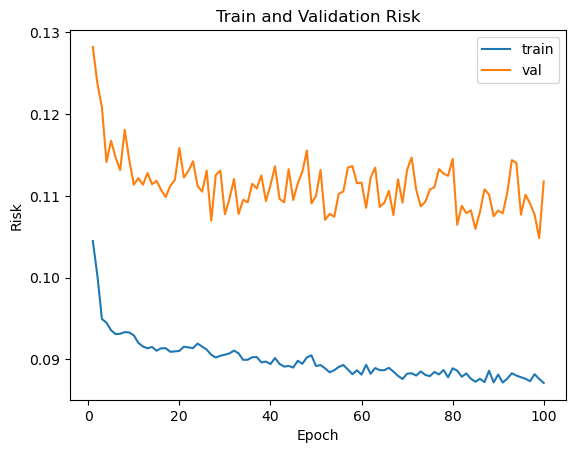

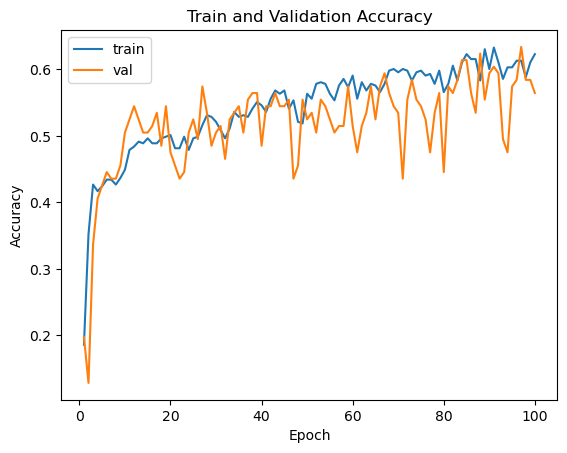

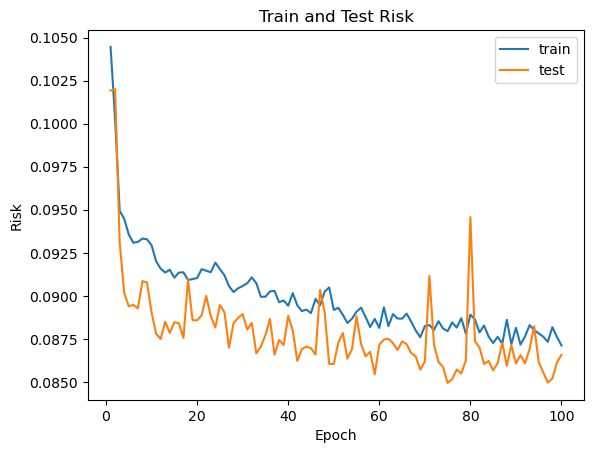

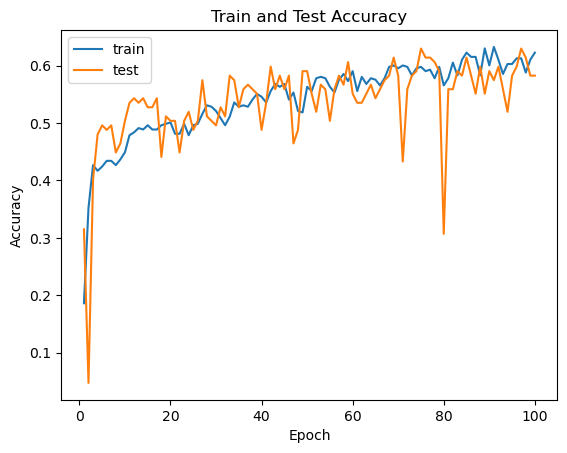

In [15]:
num_epochs = 100
train_risk, val_risk, train_accuracy, val_accuracy, test_risk, test_accuracy = train(pointnet, num_epochs, device)